to connect to the database, you need to open up a tunnel from the command line, e.g.: 

```$ ssh -fNL 27017:localhost:27017 {username}@stanfordmemorylab.com```

and then enter your password

if you don't already have the mongo database-related password information locally 

```$  scp -r chris @stanfordmemorylab.com:/home/chris/face_experiment/credentials/ local/path/to/save/credentials```

In [1]:
import pickle, pandas, os, json, pymongo, numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
from datetime import datetime
from PIL import Image

In [2]:
%matplotlib inline

In [3]:
# def establish_mongo_connection(location, keyname, mongo_database, mongo_collection): 
#     """
#     connect to database. Requires a connection to server was established via terminal, e.g.
#     $ ssh -fNL 27017:localhost:27017 tyler@stanfordmemorylab.com
#     """
#     # load information from credentials
#     access_info = json.load(open(location + keyname))
#     # set up the 'tunnel' we'll be using to access the server
#     mongo_tunnel = 'mongodb://' + access_info['user'] + ':' + access_info['pwd'] + '@127.0.0.1'
#     # conect to the mongo client on the server
#     connection = pymongo.MongoClient(mongo_tunnel)
#     # connect to the database
#     data_base = connection[mongo_database]
#     # connect to the collection
#     collection = data_base[mongo_collection]
    
#     return collection

In [4]:
# credential location -- this a copy of the credentials folder on the server
location = 'credentials/'
# aws key name 
aws_rootkey = 'aws_keys.json'
# mongo key name
keyname = 'mongo_keys'

In [5]:
access_info = json.load(open(location + keyname))
# set up the 'tunnel' we'll be using to access the server
mongo_tunnel = 'mongodb://' + access_info['user'] + ':' + access_info['pwd'] + '@127.0.0.1'
# conect to the mongo client on the server
connection = pymongo.MongoClient(mongo_tunnel)

In [6]:
## name of mongo database to look through
mongo_database = "faces"
## name of mongo collection
mongo_collection = "classification_task"
## 
# load information from credentials
access_info = json.load(open(location + keyname))
# set up the 'tunnel' we'll be using to access the server
mongo_tunnel = 'mongodb://' + access_info['user'] + ':' + access_info['pwd'] + '@127.0.0.1'
# conect to the mongo client on the server
connection = pymongo.MongoClient(mongo_tunnel)
# connect to the database
data_base = connection[mongo_database]
# connect to the collection
collection = data_base[mongo_collection]

In [7]:
delete_collection_documents = 0
for i_collection_name in data_base.list_collection_names(): 
    i_collection = data_base[i_collection_name]
    print('collection name', i_collection_name, 'has %d documents'%len( [i for i in i_collection.find({})]))

collection name classification_task has 5052 documents


In [ ]:
# takes a while to load everything from the server
all_trials = [i for i in collection.find({})]
trial_df = pandas.DataFrame({})
summary_df = pandas.DataFrame({})

for i_trial in all_trials: 
    if 'id' in i_trial: 
        trial_df = trial_df.append( {i: i_trial[i] for i in i_trial}, ignore_index=True) 
    else: 
        summary_df = summary_df.append( {i: i_trial[i] for i in i_trial}, ignore_index=True)

In [ ]:
save_data = 1 

if save_data: 
    mongo_info = '%s_%s_%s.csv'%(mongo_database, mongo_collection, datetime.today().strftime("%d_%m_%Y"))

    summary_df.to_csv('summarydata_%s.csv'%mongo_info)
    trial_df.to_csv('trialdata_%s.csv'%mongo_info) 

In [ ]:
rsps = [trial_df.iloc[i].response_race[0] for i in range(len(trial_df)) if len(trial_df.iloc[i].response_race)>1]
groups = np.unique( rsps )

In [ ]:
id_counts = {} 
id_list = [] 
for i_id in trial_df.id.unique(): 
    
    idtrials = trial_df[ trial_df.id == i_id] 
    id_lables = [i for i in [i[0] for i in idtrials.response_race if (len(i)>0)] if i in groups]
    id_vector = [np.sum( np.array(id_lables) == i) for i in groups] 
    id_counts[i_id] = id_vector/np.sum( id_vector ) 
    id_list.append( id_counts[i_id] )
    #plt.plot( [np.sum( np.array(id_counts[i_id]) == i) for i in groups]  )

In [ ]:
plt.hist([groups [ id_counts[i].argmax() ] for i in id_counts]); 
plt.title('using "max" classification strategy', y=1.05); 
plt.xlabel('\n\nGROUP'); 

In [ ]:
plt.hist([groups [ id_counts[i].argmax() ] for i in id_counts]); 
plt.hist([groups [ id_counts[i].argmax() ] for i in id_counts if id_counts[i].max()>.50]); 
plt.hist([groups [ id_counts[i].argmax() ] for i in id_counts if id_counts[i].max()>.70]);
plt.xlabel('\n\nGROUP'); 

In [ ]:
for i_group in groups: 
    group_vals = [id_counts[i].max() for i in id_counts if groups[id_counts[i].argmax()]==i_group]
    plt.scatter(x=np.ones(len(group_vals))* np.argmax( groups==i_group ), y=group_vals, alpha=.5
               ) 
plt.xticks(range(len(groups)), groups); 
plt.title('ratio of labels within the "max" category for each image')

In [ ]:
id_reliability = {} 
n_iterations = 50 
null = {} 

for i_id in trial_df.id.unique(): 
    
    idtrials = trial_df[ trial_df.id == i_id] 
    
    id_lables = [i for i in [i[0] for i in idtrials.response_race if (len(i)>0)] if i in groups]
    
    permutations = [] 
    nullspace = [] 
    for i_iteration in range(n_iterations): 
        
        shuffled_labels = np.random.permutation( id_lables ) 
        
        shuffled_a = shuffled_labels[:len(shuffled_labels)//2]
        shuffled_b = shuffled_labels[len(shuffled_labels)//2:]

        vector_a = [np.sum( np.array(shuffled_a) == i) for i in groups]
        vector_b = [np.sum( np.array(shuffled_b) == i) for i in groups]

        vector_a = vector_a/np.sum(vector_a)
        vector_b = vector_b/np.sum(vector_b)
        
        permutations.append(  np.corrcoef( vector_a, vector_b)[0, 1] )
        nullspace.append(  np.corrcoef( vector_a, np.random.permutation(vector_b))[0, 1] )
    
    id_reliability[i_id] = np.median( permutations ) 
    null[i_id] = np.median( nullspace ) 

In [ ]:
plt.hist([id_reliability[i] for i in id_reliability], bins=30) ; 
plt.xlabel('split half reliability (across participants) for ratings of each image')
plt.hist([null[i] for i in null], bins=20, alpha=.2, color='grey') ; 

In [ ]:
plt.figure(figsize=[5,5])
colors = {'black':'red',  'white':'blue', 
          'east_asian':'pink', 'south_asian':'purple',
          'latinx':'green', 'other':'yellow',}
for i_group in groups: 
    
    group_maxdata = [] 
    group_reliability = [] 
        
    for i_idx in id_counts: 
        
        if groups[id_counts[i_idx].argmax()]==i_group: 

            group_maxdata.append( id_counts[i_idx].max()) 
            group_reliability.append( id_reliability[i_idx])
            
    plt.scatter(x=group_reliability, y=group_maxdata, facecolor='', edgecolor=colors[i_group], 
                linewidth=.8, 
                label=i_group)
    plt.xlabel('split-half reliabilty for each image across participants', y=-3)
    plt.ylabel('max value for each image')
plt.legend()
plt.title('relationship between each image\'s "max" value \nand inter-rater reliability ', y=1.05)
plt.plot([-1, 2], [-1, 2], color='grey', linestyle=':')
plt.ylim([.15, 1.1])
plt.xlim([.15, 1.1])

In [ ]:
sorted_ids = np.sort(list(id_counts)) 
sorted_groups = {} 

for i_group in groups: 
    
    group_ratings = [id_counts[i_id][ np.argmax( i_group == groups ) ] for i_id in sorted_ids]
    sorted_groups[i_group] = np.array( sorted_ids) [ np.array(group_ratings).argsort()[::-1] ] # decending order
    

In [ ]:
plt.figure(figsize=[15,6])
iplot=1
for i_group in groups: 
    
    i_id = sorted_groups[i_group][0]
    path  = '/Users/biota/working/faces/experiment_images'
    i_image = '%s/id%s_00C_C.png'%(path, i_id)
    plt.subplot(2,3,iplot); iplot+=1 
    image_array = np.array( Image.open(i_image) )
    plt.imshow( image_array )
    plt.axis('off')
    plt.title( i_group.upper()  ); 
    for ratio in range(len(groups)): 
        plt.text(len(image_array), 120 + ratio*50, '%.02f, %s'%(id_counts[i_id][ratio], groups[ratio]),
                fontsize=13)

plt.suptitle('visualizing the most reliably rated ids for each category', y=1.05, fontsize=15); 

In [ ]:
for i_group in groups: 
    
    plt.figure(figsize=[15,6])
    iplot=1
    for i_face in range(6): 
        i_id = sorted_groups[i_group][i_face]
        path  = '/Users/biota/working/faces/experiment_images'
        i_image = '%s/id%s_00C_C.png'%(path, i_id)
        plt.subplot(2,3,iplot); iplot+=1 
        image_array = np.array( Image.open(i_image) )
        plt.imshow( image_array )
        plt.axis('off')
        for ratio in range(len(groups)): 
            plt.text(len(image_array), 120 + ratio*50, '%.02f, %s'%(id_counts[i_id][ratio], groups[ratio]),
                    fontsize=12)
        
    plt.suptitle('visualizing the n reliably rated ids for category: %s'%i_group, y=1.05, fontsize=15); 

In [ ]:
plt.figure(figsize=[15,6])
iplot=1
path  = '/Users/biota/working/faces/experiment_images'
for i_id in np.random.permutation(list( id_counts ))[:6]: 
    
    i_image = '%s/id%s_00C_C.png'%(path, i_id)
    plt.subplot(2,3,iplot); iplot+=1 
    image_array = np.array( Image.open(i_image) )
    plt.imshow( image_array )
    plt.axis('off')
    plt.title( 'face mostly rated as %s'%groups[ id_counts[i_id].argmax() ]  ); 
    for ratio in range(len(groups)): 
        plt.text(len(image_array), 120 + ratio*50, '%.02f, %s'%(id_counts[i_id][ratio], groups[ratio]),
                fontsize=13)

plt.suptitle('visualizing random faces', y=1.05, fontsize=15); 

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array( id_list )
iplot = 1
plt.figure(figsize=[15,10])
for i_cluster in [2,3,4,5,6,7]: 
    kmeans = KMeans(n_clusters=i_cluster, random_state=0).fit(X)
    kmeans.labels_

    sorted_list = [] 
    sorted_labels = [] 

    for group in np.unique( kmeans.labels_ ): 
        for i in range(len(id_list)): 
            if kmeans.labels_[i] == group:
                sorted_list.append( id_list[i])
        sorted_list.append( np.zeros(len(groups)))
        sorted_list.append( np.zeros(len(groups)))
        sorted_list.append( np.zeros(len(groups)))
    
    plt.subplot(2,3,iplot); iplot+=1
    plt.imshow( np.corrcoef( sorted_list ) , cmap='viridis') 
    plt.xticks( range(len( sorted_labels )), sorted_labels, size=2); 
    plt.title('n clusters is %d'%i_cluster)
    plt.axis('off')

In [ ]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 7

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(id_list)
    labels = kmeans.labels_
    sil.append(silhouette_score(id_list, labels, metric = 'euclidean'))

Sum_of_squared_distances = []
K = range(1,kmax)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(id_list)
    Sum_of_squared_distances.append(km.inertia_)

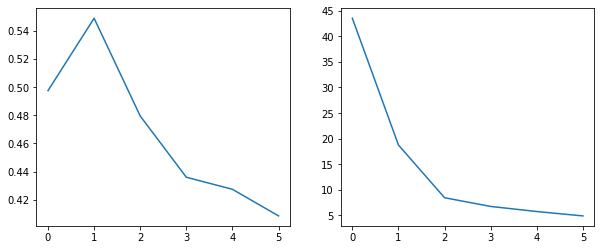

In [37]:
plt.figure(figsize=[10,4])
plt.subplot(121)
plt.plot( sil )

plt.subplot(122)
plt.plot( Sum_of_squared_distances )